<a href="https://colab.research.google.com/github/simplysowj/Adultdataset/blob/main/Copy_of_Mlops_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement:**
Identify which questions asked on Quora are duplicates of questions that have already been asked.


*   This can be helpful for providing instant responses to questions that have already been addressed.




# **Objective:**
The goal of this project is to predict which of the provided pairs of questions contain two questions with the same meaning. 
# Real World/Business Objectives and Constraints:






*   The cost of a mis-classification can be very high.
*   You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
*   No strict latency concerns.
*   Interpretability is partially important.





# **About Dataset**

The dataset "Train.csv" contains **404,290 rows**and **5 columns**

#Data fields
**id** - the id of a training set question pair

**qid1, qid2** - unique ids of each question (only available in train.csv)

**question1, question2** - the full text of each question

**is_duplicate** - is the dependent variable, and the target variable is set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

> Install and import necessary libraries and modules.



In [ ]:
!pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 5.2 MB/s 
     |████████████████████████████████| 106 kB 67.3 MB/s 


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 5.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
import nltk
import contractions
import distance
import time
import neattext as nt 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from random import randint
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

> Load the Dataset

In [ ]:

from google.colab import files
 
 
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:

import pandas as pd
import io
 
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
print(df)

            id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
404285  404285  433578  379845   
404286  404286   18840  155606   
404287  404287  537928  537929   
404288  404288  537930  537931   
404289  404289  537932  537933   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287                                  Wh

> Check the Shape of dataset

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
print("Available Columns : ", df.columns)
print("\nis_duplicates Class labels",df.is_duplicate.unique())
print("\nNo. of non-duplicate data points(0) and No. of duplicate data points(1) are :\n")
df.is_duplicate.value_counts()

Available Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

is_duplicates Class labels [0 1]

No. of non-duplicate data points(0) and No. of duplicate data points(1) are :



0    255027
1    149263
Name: is_duplicate, dtype: int64

# Distribution of data points among output classes

Number of duplicate(smilar) and non-duplicate(non similar) questions

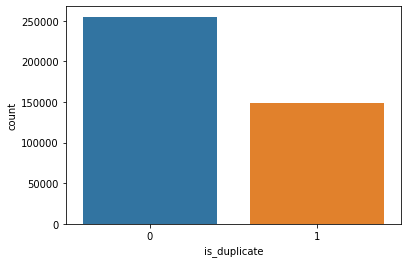

In [ ]:
sns.countplot(df["is_duplicate"])
plt.show()

In [ ]:
print('Percentage of dissimilar pair of questions (is_duplicate = 0): {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nPercentage of similar pair of questions (is_duplicate = 1): {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Percentage of dissimilar pair of questions (is_duplicate = 0): 63.08%

Percentage of similar pair of questions (is_duplicate = 1): 36.92%


> **63.08%** of questions pair are not duplicates and **36.92%** of question pairs are duplicates.

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
repeated_qids = np.sum(qids.value_counts() > 1)
print("Total no. unique qids: ", unique_qids)
print("\nToatal no. of repeated qids: ", repeated_qids)

Total no. unique qids:  537933

Toatal no. of repeated qids:  111780


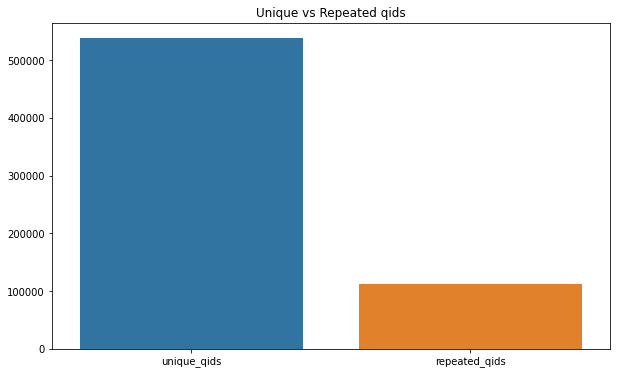

In [ ]:
x = ["unique_qids" , "repeated_qids"]
y =  [unique_qids , repeated_qids]

plt.figure(figsize=(10, 6))
plt.title ("Unique vs Repeated qids")
sns.barplot(x,y)
plt.show()

> Let's check whether there are any repeated pair of questions.

In [ ]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate pair of questions:",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate pair of questions: 0


> Let us visually plot the no. of times a question is repeated.

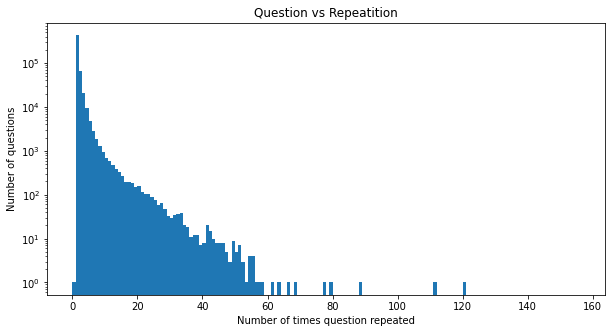

0 157


In [ ]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print(np.min(occurences), np.max(occurences))

> Check whether there are any rows with null values.

In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

> As we notice they are total 3 null values 1 in question1 and 2 in question2,  let us print those null rows

In [ ]:
null_rows = df[df.isnull().any(1)]
print (null_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


> Fill the null rows with ' '

In [ ]:
df = df.fillna('')

> Check wheather null rows are filled.

In [ ]:
null_rows = df[df.isnull().any(1)]
print (null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

> As we notice know the null rows are filled i.e, our dataset doesn't contain any more null rows

In [ ]:
df.duplicated().sum()

0

> There are no duplicates in our dataset

# Basic Data Cleaning
Perform below actions on question1 and question2 columns of the datset:
*   Remove html tags
*   Remove Stopwords
*   Expand Contractions
*   Remove Punctuations
*   Convert entire text to lowercase
*   Remove Special Characters

In [ ]:
start_time=time.time()
######### Data Cleaning of question1 column##########
quest1=[]
for i in df['question1']:
  docx = nt.TextFrame(text=str(i))
  docx.remove_html_tags()
  docx.remove_stopwords()
  docx.fix_contractions()
  docx.remove_puncts()
  t=docx.text.lower()
  text = re.sub(r'[^a-z A-Z 0-9]', '', t)
  quest1.append(text)
######################################################
end_time=time.time()
total_time=(end_time-start_time)/60
print("\nTime in min:",total_time)


Time in min: 0.9341377218564352


In [ ]:
start_time=time.time()
######### Data Cleaning of question2 column##########
quest2=[]
for i in df['question2']:
  docx = nt.TextFrame(text=str(i))
  docx.remove_html_tags()
  docx.remove_stopwords()
  docx.fix_contractions()
  docx.remove_puncts()
  t=docx.text.lower()
  text = re.sub(r'[^a-z A-Z 0-9]', '', t)
  quest2.append(text)
end_time=time.time()
######################################################
total_time=(end_time-start_time)/60
print("\nTime in min:",total_time)


Time in min: 0.9302854180335999


> Apply POS Tagging

In [ ]:
def pos_tag(sentence):
  text = word_tokenize(sentence)
  return nltk.pos_tag(text)

res=[]
for sentence in quest1:
  res.append(pos_tag(sentence))

In [ ]:
def pos_tag(sentence):
  text = word_tokenize(sentence)
  return nltk.pos_tag(text)

res1=[]
for sentence in quest2:
  res1.append(pos_tag(sentence))

In [ ]:
data={'preprocessed_q1' : quest1,'preprocessed_q2' : quest2, 'POS_q1': res,'POS_q2': res1}
df1=pd.DataFrame(data)

> Creating new preprocessed dataset

In [ ]:
new_df=pd.concat([df['id'],df['qid1'],df['qid2'],df1['preprocessed_q1'],df1['preprocessed_q2'],df['is_duplicate'],df1['POS_q1'],df1['POS_q2']],axis=1)

In [ ]:
new_df.head()

,id,qid1,qid2,preprocessed_q1,preprocessed_q2,is_duplicate,POS_q1,POS_q2
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,"[(step, NN), (step, NN), (guide, RB), (invest,...","[(step, NN), (step, NN), (guide, RB), (invest,..."
1,1,3,4,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...,0,"[(story, NN), (kohinoor, NN), (kohinoor, NN), ...","[(happen, VB), (indian, JJ), (government, NN),..."
2,2,5,6,increase speed internet connection vpn,internet speed increased hacking dns,0,"[(increase, NN), (speed, NN), (internet, JJ), ...","[(internet, JJ), (speed, NN), (increased, VBD)..."
3,3,7,8,mentally lonely solve it,find remainder math2324math divided 2423,0,"[(mentally, RB), (lonely, RB), (solve, VB), (i...","[(find, VB), (remainder, NN), (math2324math, N..."
4,4,9,10,dissolve water quikly sugar salt methane carbo...,fish survive salt water,0,"[(dissolve, NN), (water, NN), (quikly, NN), (s...","[(fish, JJ), (survive, NN), (salt, NN), (water..."


> Checking for null values in new dataframe(new_df)

In [ ]:
new_df.isnull().sum()

id                 0
qid1               0
qid2               0
preprocessed_q1    0
preprocessed_q2    0
is_duplicate       0
POS_q1             0
POS_q2             0
dtype: int64

# Apply **Tokenization** , **Stemming** and **Lemmatization** on 

# preprocessed_q1 and preprocessed_q2 columns.

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(raw_review, flag):
    # Tokenize
    words = raw_review.split()
    # Stemming
    if flag == 'Stem':
        words = [stemmer.stem(word) for word in words]
    #Lemmatization
    else:
        words = [lemmatizer.lemmatize(word) for word in words]     
    clean_review_list.append(' '.join(words))  
    len_review_list.append(len(words))

> Add new columns "**clean_q1_stem**","**clean_q2_stem**" to the dataframe new_df.
> where, 
- **clean_q1_stem** column represents preprocessed_q1 column after appling stemming
- **clean_q2_stem** column represents preprocessed_q2 column after appling stemming

In [ ]:
clean_review_list = []
len_review_list = []

In [ ]:
new_df['preprocessed_q1'].progress_apply(lambda x: preprocess(x,'Stem'))
new_df['Clean_q1_stem'] = clean_review_list


100%|██████████| 404290/404290 [00:49<00:00, 8144.83it/s]


In [ ]:
clean_review_list = []
len_review_list = []

In [ ]:
new_df['preprocessed_q2'].progress_apply(lambda x: preprocess(x,'Stem'))
new_df['Clean_q2_stem'] = clean_review_list

100%|██████████| 404290/404290 [00:50<00:00, 8069.93it/s]


> Add new columns "**clean_q1_lem**","**clean_q2_lem**" to the dataframe new_df.
> where, 
- **clean_q1_lem** column represents preprocessed_q1 column after appling lemmatization
- **clean_q2_lem** column represents preprocessed_q2 column after appling lemmatization

In [ ]:
clean_review_list = []
len_review_list = []

In [ ]:
new_df['preprocessed_q1'].progress_apply(lambda x: preprocess(x,'Lem'))
new_df['Clean_q1_lem'] = clean_review_list
new_df['q1_len'] = len_review_list

100%|██████████| 404290/404290 [00:12<00:00, 31856.79it/s]


In [ ]:
clean_review_list = []
len_review_list = []

In [ ]:
new_df['preprocessed_q2'].progress_apply(lambda x: preprocess(x,'Lem'))
new_df['Clean_q2_lem'] = clean_review_list
new_df['q2_len'] = len_review_list

100%|██████████| 404290/404290 [00:10<00:00, 37667.15it/s]


In [ ]:
new_df.loc[:,['id',	'qid1',	'qid2',	'preprocessed_q1',	'preprocessed_q2',	'is_duplicate',	'q1_len' ,	'q2_len','POS_q1','POS_q2',	'Clean_q1_stem'	, 'Clean_q2_stem',	'Clean_q1_lem',	'Clean_q2_lem']]

,id,qid1,qid2,preprocessed_q1,preprocessed_q2,is_duplicate,q1_len,q2_len,POS_q1,POS_q2,Clean_q1_stem,Clean_q2_stem,Clean_q1_lem,Clean_q2_lem
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,7,6,"[(step, NN), (step, NN), (guide, RB), (invest,...","[(step, NN), (step, NN), (guide, RB), (invest,...",step step guid invest share market india,step step guid invest share market,step step guide invest share market india,step step guide invest share market
1,1,3,4,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...,0,4,8,"[(story, NN), (kohinoor, NN), (kohinoor, NN), ...","[(happen, VB), (indian, JJ), (government, NN),...",stori kohinoor kohinoor diamond,happen indian govern stole kohinoor kohinoor d...,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...
2,2,5,6,increase speed internet connection vpn,internet speed increased hacking dns,0,5,5,"[(increase, NN), (speed, NN), (internet, JJ), ...","[(internet, JJ), (speed, NN), (increased, VBD)...",increas speed internet connect vpn,internet speed increas hack dn,increase speed internet connection vpn,internet speed increased hacking dns
3,3,7,8,mentally lonely solve it,find remainder math2324math divided 2423,0,4,5,"[(mentally, RB), (lonely, RB), (solve, VB), (i...","[(find, VB), (remainder, NN), (math2324math, N...",mental lone solv it,find remaind math2324math divid 2423,mentally lonely solve it,find remainder math2324math divided 2423
4,4,9,10,dissolve water quikly sugar salt methane carbo...,fish survive salt water,0,9,4,"[(dissolve, NN), (water, NN), (quikly, NN), (s...","[(fish, JJ), (survive, NN), (salt, NN), (water...",dissolv water quikli sugar salt methan carbon ...,fish surviv salt water,dissolve water quikly sugar salt methane carbo...,fish survive salt water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,keywords racket programming language latest ve...,keywords perl programming language latest version,0,6,6,"[(keywords, NNS), (racket, NN), (programming, ...","[(keywords, NNS), (perl, VBP), (programming, V...",keyword racket program languag latest version,keyword perl program languag latest version,keywords racket programming language latest ve...,keywords perl programming language latest version
404286,404286,18840,155606,believe life death,true life death,1,3,3,"[(believe, JJ), (life, NN), (death, NN)]","[(true, JJ), (life, NN), (death, NN)]",believ life death,true life death,believe life death,true life death
404287,404287,537928,537929,coin,whats coin,0,1,2,"[(coin, NN)]","[(whats, NNS), (coin, VBP)]",coin,what coin,coin,whats coin
404288,404288,537930,537931,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,0,9,12,"[(approx, JJ), (annual, JJ), (cost, NN), (livi...","[(little, JJ), (hairfall, NN), (problem, NN), ...",approx annual cost live studi uic chicago indi...,littl hairfal problem want use hair style prod...,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...


In [ ]:
new_df.head()

,id,qid1,qid2,preprocessed_q1,preprocessed_q2,is_duplicate,POS_q1,POS_q2,Clean_q1_stem,Clean_q2_stem,Clean_q1_lem,q1_len,Clean_q2_lem,q2_len
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,"[(step, NN), (step, NN), (guide, RB), (invest,...","[(step, NN), (step, NN), (guide, RB), (invest,...",step step guid invest share market india,step step guid invest share market,step step guide invest share market india,7,step step guide invest share market,6
1,1,3,4,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...,0,"[(story, NN), (kohinoor, NN), (kohinoor, NN), ...","[(happen, VB), (indian, JJ), (government, NN),...",stori kohinoor kohinoor diamond,happen indian govern stole kohinoor kohinoor d...,story kohinoor kohinoor diamond,4,happen indian government stole kohinoor kohino...,8
2,2,5,6,increase speed internet connection vpn,internet speed increased hacking dns,0,"[(increase, NN), (speed, NN), (internet, JJ), ...","[(internet, JJ), (speed, NN), (increased, VBD)...",increas speed internet connect vpn,internet speed increas hack dn,increase speed internet connection vpn,5,internet speed increased hacking dns,5
3,3,7,8,mentally lonely solve it,find remainder math2324math divided 2423,0,"[(mentally, RB), (lonely, RB), (solve, VB), (i...","[(find, VB), (remainder, NN), (math2324math, N...",mental lone solv it,find remaind math2324math divid 2423,mentally lonely solve it,4,find remainder math2324math divided 2423,5
4,4,9,10,dissolve water quikly sugar salt methane carbo...,fish survive salt water,0,"[(dissolve, NN), (water, NN), (quikly, NN), (s...","[(fish, JJ), (survive, NN), (salt, NN), (water...",dissolv water quikli sugar salt methan carbon ...,fish surviv salt water,dissolve water quikly sugar salt methane carbo...,9,fish survive salt water,4


> Since, lemmatization results are better than stemming result, we will use lammatized columns for further steps.

> Know, since we are done with cleaning of our dataset let us create a new dataframe named "**workon_df**", which consist of 6 columns named as: id, qid1, qid2, Question1, Question2, is_duplicate.

> Where,
- "**Question1**" represents cleaned form of "question1" provided in train.csv 
i.e, it represents "question1 column of df" after removing html tags, punctuations, specialcharacters, stopwords followed by lowercase conversion, expanding contractions, tokenization and lammitization.
- "**Question2**" represents cleaned form of "question2" provided in train.csv 
i.e, it represents "question1 column of df" after removing html tags, punctuations, specialcharacters, stopwords followed by lowercase conversion, expanding contractions, tokenization and lammitization.

In [ ]:
data={'Question1' :new_df['Clean_q1_lem']	,'Question2' : new_df['Clean_q2_lem']}
df2=pd.DataFrame(data)

In [ ]:
workon_df=pd.concat([df['id'],df['qid1'],df['qid2'],df2['Question1'],df2['Question2'],df['is_duplicate']],axis=1)

> Display head() of "workon_df"

In [ ]:
workon_df.head()

,id,qid1,qid2,Question1,Question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...,0
2,2,5,6,increase speed internet connection vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve it,find remainder math2324math divided 2423,0
4,4,9,10,dissolve water quikly sugar salt methane carbo...,fish survive salt water,0


In [ ]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)
    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

# Word Cloud for Question1

Word Cloud for Question1:


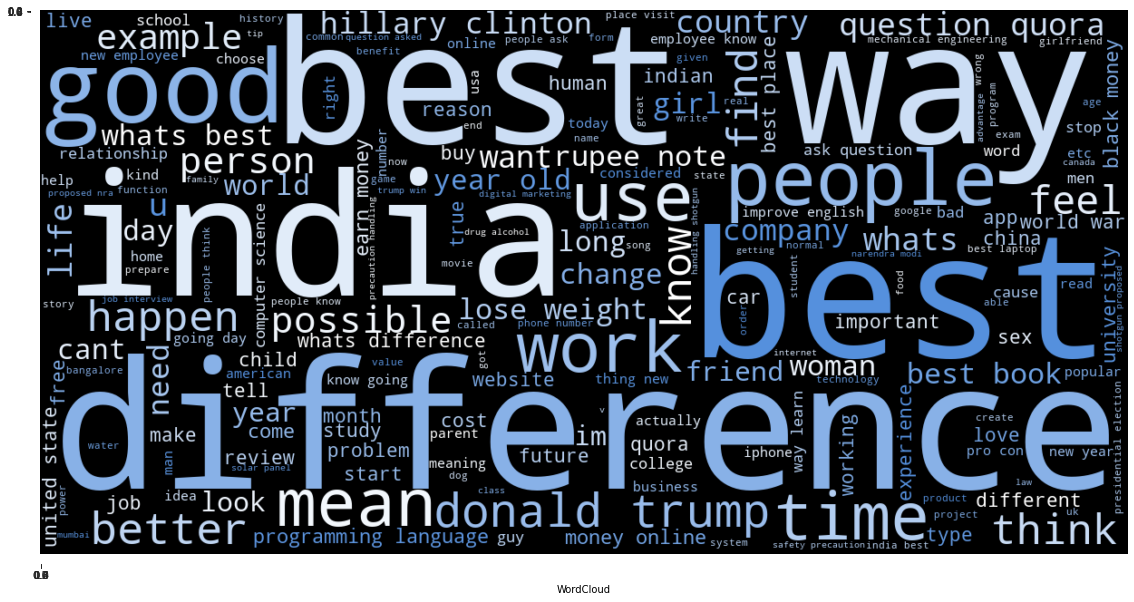

In [ ]:
print("Word Cloud for Question1:")
plot_wordcloud(' '.join(workon_df.Question1.values.tolist()), wc_blue_color_func)

# Word Cloud for Question2

Word Cloud for Question2:


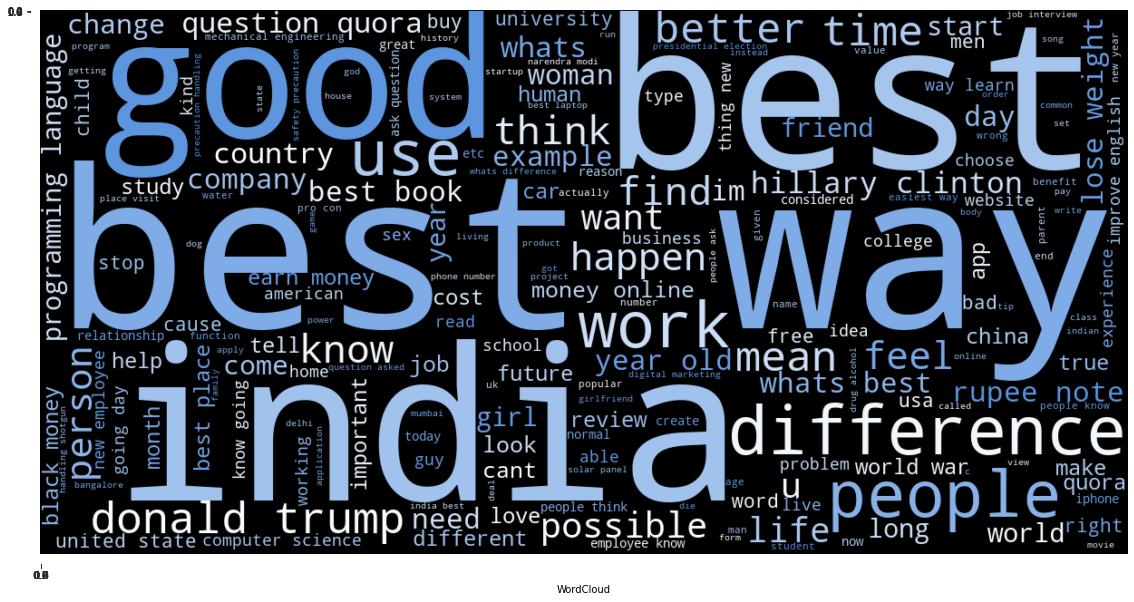

In [ ]:
print("Word Cloud for Question2:")
plot_wordcloud(' '.join(workon_df.Question2.values.tolist()), wc_blue_color_func)

# Work Cloud for Duplicate Question Pairs

Word Cloud for Duplicate Question pairs


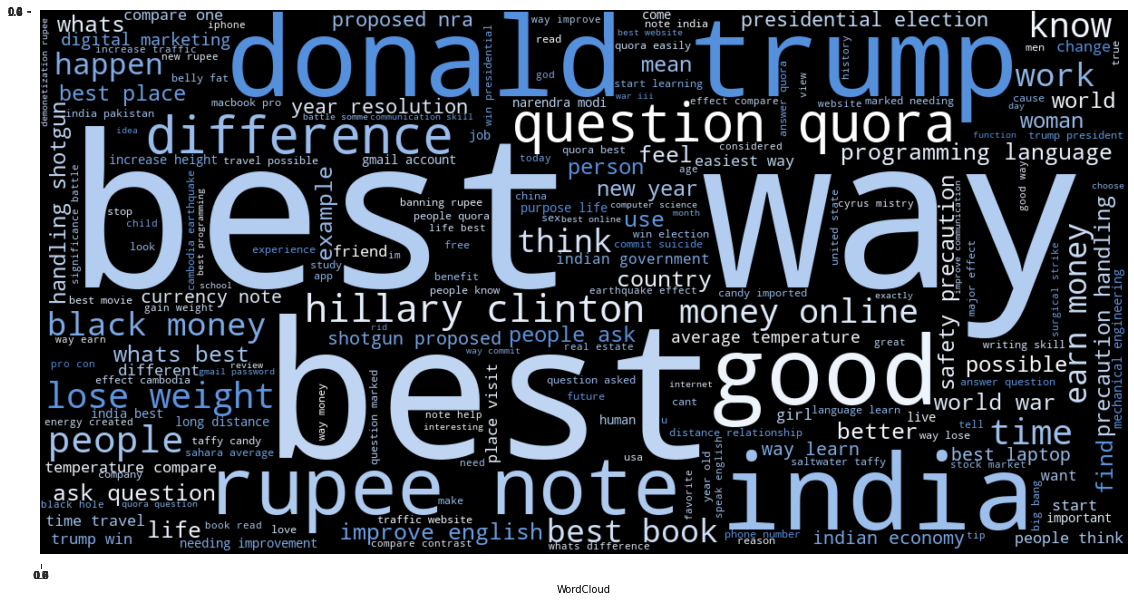

In [ ]:
print ("Word Cloud for Duplicate Question pairs")
plot_wordcloud(' '.join(workon_df['Question1'].loc[workon_df['is_duplicate'] == 1].values.tolist() and workon_df['Question2'].loc[workon_df['is_duplicate'] == 1].values.tolist()), wc_blue_color_func)

# Work Cloud for Non-Duplicate Question Pairs

Word Cloud for Non-Duplicate Question pairs


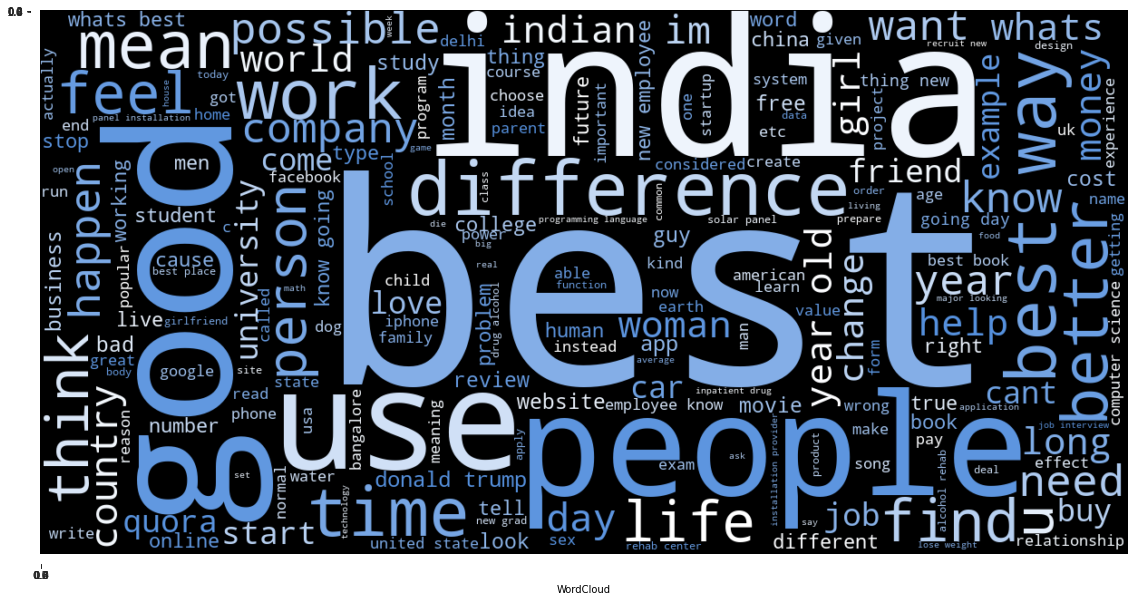

In [ ]:
print ("Word Cloud for Non-Duplicate Question pairs")
plot_wordcloud(' '.join(workon_df['Question1'].loc[workon_df['is_duplicate'] == 0].values.tolist() and workon_df['Question2'].loc[workon_df['is_duplicate'] == 0].values.tolist()), wc_blue_color_func)

# Plot count of length of words in Question1 and Question2 

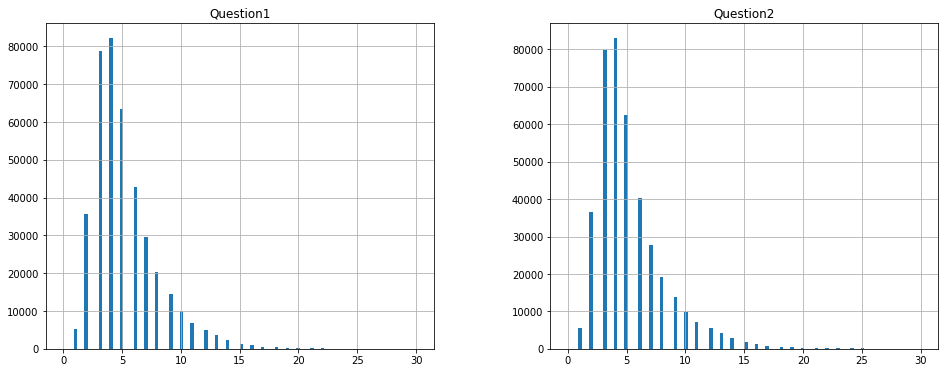

In [ ]:
Question1_count = [len(sentence.split()) for sentence in workon_df.Question1]
Question2_count = [len(sentence.split()) for sentence in workon_df.Question2]

pd.DataFrame({'Question1':Question1_count, 'Question2': Question2_count}).hist(bins=100, figsize=(16, 6), range=[0, 30])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


print("Percentage of Question1 having 0-25 words: ",get_word_percent(workon_df.Question1,25 ))
print("\nPercentage of Question1 having 0-10 words: ",get_word_percent(workon_df.Question1,10 ))

print("\nPercentage of Question2 having 0-25 words: ",get_word_percent(workon_df.Question2, 25))
print("\nPercentage of Question2 having 0-10 words: ",get_word_percent(workon_df.Question2, 10))

Percentage of Question1 having 0-25 words:  1.0

Percentage of Question1 having 0-10 words:  0.95

Percentage of Question2 having 0-25 words:  1.0

Percentage of Question2 having 0-10 words:  0.94


> We can notice that almost 95% of words are in range 0 to 10 for both Question1 and Question2.

> And there very few questions for both Question1 and Question2 which have count of words greater than 10.

In [ ]:
workon_df

,id,qid1,qid2,Question1,Question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...,0
2,2,5,6,increase speed internet connection vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve it,find remainder math2324math divided 2423,0
4,4,9,10,dissolve water quikly sugar salt methane carbo...,fish survive salt water,0
...,...,...,...,...,...,...
404285,404285,433578,379845,keywords racket programming language latest ve...,keywords perl programming language latest version,0
404286,404286,18840,155606,believe life death,true life death,1
404287,404287,537928,537929,coin,whats coin,0
404288,404288,537930,537931,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,0


In [ ]:
X = workon_df.drop('is_duplicate', axis=1)

In [ ]:
y = workon_df.is_duplicate

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=1)

In [ ]:
X_train.head()

,id,qid1,qid2,Question1,Question2
394617,394617,527528,527529,ceo law school grade competitive,whats good online discussion board air daily f...
146735,146735,60120,231728,singapore citizen obtain citizenship dual nati...,american cross canadian border child child dua...
231076,231076,340783,167045,rid pimple earlobe,rid pimple ear
66117,66117,103992,26685,releasing new 500 2000 rupee note help eradica...,pm modi want curb black money new 2000 rupee n...
114046,114046,8431,89956,possible solution forgot icloud password,icloud password


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vocab = CountVectorizer(max_features=300)

In [ ]:
questions_train=list(X_train['Question1'])+list(X_train['Question2'])

In [ ]:
q1_bow_train,q2_bow_train=np.vsplit(vocab.fit_transform(questions_train).toarray(),2)

In [ ]:
temp_df1_train=pd.DataFrame(q1_bow_train,index=X_train.index)
temp_df2_train=pd.DataFrame(q2_bow_train,index=X_train.index)
temp_df_train=pd.concat([temp_df1_train,temp_df2_train],axis=1)
temp_df_train.shape

(303217, 600)

In [ ]:
questions_test=list(X_test['Question1'])+list(X_test['Question2'])

In [ ]:
q1_bow_test,q2_bow_test=np.vsplit(vocab.transform(questions_test).toarray(),2)

In [ ]:
temp_df1_test=pd.DataFrame(q1_bow_test,index=X_test.index)
temp_df2_test=pd.DataFrame(q2_bow_test,index=X_test.index)
temp_df_test=pd.concat([temp_df1_test,temp_df2_test],axis=1)
temp_df_test.shape

(101073, 600)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(temp_df_train, y_train)

LogisticRegression()

In [ ]:
y_test_pred = classifier.predict(temp_df_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.6918959563879572
              precision    recall  f1-score   support

           0       0.70      0.90      0.79     63737
           1       0.67      0.33      0.44     37336

    accuracy                           0.69    101073
   macro avg       0.68      0.62      0.62    101073
weighted avg       0.69      0.69      0.66    101073



In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(temp_df_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
y_test_pred = classifier.predict(temp_df_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

In [ ]:
from pickle import dump

In [ ]:
dump(classifier, open('Models/logistic.pkl','wb'))
dump(vocab, open('Models/vect.pkl', 'wb'))

FileNotFoundError: ignored

In [ ]:
import pickle

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
PATH='/content/drive/My Drive/Models'

In [ ]:
file_name='log.pkl'

In [ ]:
path_to_embed = os.path.join(PATH,file_name)

In [ ]:
dump(classifier, open(path_to_embed,'wb'))


In [ ]:
file_name1='vect.pkl'

In [ ]:
path_to_embed1 = os.path.join(PATH,file_name1)

In [ ]:
dump(vocab, open(path_to_embed1, 'wb'))